In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/collab/Extended_Employee_Performance_and_Productivity_Data.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count,min, max
from pyspark.ml import Pipeline


#Creating a Spark Session
spark = SparkSession.builder.appName("Pred&AnalysEmployeeAttrition").getOrCreate()

#Loading the data
data = spark.read.csv(path, header=True, inferSchema=True)

data = data.na.drop()

data.printSchema()
data.show(25)



root
 |-- Employee_ID: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Hire_Date: timestamp (nullable = true)
 |-- Years_At_Company: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Performance_Score: integer (nullable = true)
 |-- Monthly_Salary: double (nullable = true)
 |-- Work_Hours_Per_Week: integer (nullable = true)
 |-- Projects_Handled: integer (nullable = true)
 |-- Overtime_Hours: integer (nullable = true)
 |-- Sick_Days: integer (nullable = true)
 |-- Remote_Work_Frequency: integer (nullable = true)
 |-- Team_Size: integer (nullable = true)
 |-- Training_Hours: integer (nullable = true)
 |-- Promotions: integer (nullable = true)
 |-- Employee_Satisfaction_Score: double (nullable = true)
 |-- Resigned: boolean (nullable = true)

+-----------+----------------+------+---+----------+--------------------+--------

In [3]:
#Calculating and Displaying Unique Value Counts per Column
for column in data.columns:
    unique_count = data.select(column).distinct().count()
    print(f"{column}: Number of unique values {unique_count}")
    print("==========================================================")

Employee_ID: Number of unique values 100000
Department: Number of unique values 9
Gender: Number of unique values 3
Age: Number of unique values 39
Job_Title: Number of unique values 7
Hire_Date: Number of unique values 3650
Years_At_Company: Number of unique values 11
Education_Level: Number of unique values 4
Performance_Score: Number of unique values 5
Monthly_Salary: Number of unique values 28
Work_Hours_Per_Week: Number of unique values 31
Projects_Handled: Number of unique values 50
Overtime_Hours: Number of unique values 30
Sick_Days: Number of unique values 15
Remote_Work_Frequency: Number of unique values 5
Team_Size: Number of unique values 19
Training_Hours: Number of unique values 100
Promotions: Number of unique values 3
Employee_Satisfaction_Score: Number of unique values 401
Resigned: Number of unique values 2


In [4]:

for column in data.columns:
  unique_count = data.select(column).distinct().count()
  if unique_count <= 50:

        # Use the imported count function here
        value_counts = data.groupBy(column).agg(count("*").alias("count")).orderBy(col("count").desc())
        value_counts.show(truncate=False)

        print("====================================")
        if dict(data.dtypes)[column] !='string' :
          stats = data.agg(
              min(col(column)).alias("min_value"),
              max(col(column)).alias("max_value")
          ).collect()[0]

          min_val = stats["min_value"]
          max_val = stats["max_value"]

          # Print the results
          print(f"{column} : Minimum: {min_val}, Maximum: {max_val}")
          print("====================================")


+----------------+-----+
|Department      |count|
+----------------+-----+
|Marketing       |11216|
|Finance         |11200|
|Operations      |11181|
|IT              |11131|
|Sales           |11122|
|Legal           |11118|
|Customer Support|11116|
|HR              |10960|
|Engineering     |10956|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Male  |48031|
|Female|48001|
|Other |3968 |
+------+-----+

+---+-----+
|Age|count|
+---+-----+
|53 |2657 |
|27 |2628 |
|50 |2620 |
|28 |2617 |
|40 |2609 |
|46 |2604 |
|57 |2601 |
|24 |2598 |
|56 |2598 |
|39 |2596 |
|47 |2594 |
|43 |2594 |
|48 |2590 |
|52 |2586 |
|41 |2585 |
|26 |2584 |
|58 |2577 |
|51 |2576 |
|25 |2570 |
|31 |2566 |
+---+-----+
only showing top 20 rows

Age : Minimum: 22, Maximum: 60
+----------+-----+
|Job_Title |count|
+----------+-----+
|Specialist|14507|
|Manager   |14325|
|Technician|14285|
|Analyst   |14261|
|Engineer  |14217|
|Consultant|14210|
|Developer |14195|
+----------+-----+

+------------

In [5]:
from pyspark.ml.feature import VectorAssembler, StringIndexer,OneHotEncoder

In [6]:
from pyspark.sql.functions import  when
from pyspark.sql.types import IntegerType

In [7]:
data = data.withColumn("Resigned", when(col("Resigned"), 1).otherwise(0).cast(IntegerType())) # resigned col was a bool so i have to change it to numeric
indexer = StringIndexer(inputCol="Resigned", outputCol="attiration")
data = indexer.fit(data).transform(data)



string_columns = ["Department", "Gender", "Job_Title", "Education_Level"]  # Identify string columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in string_columns]

# Create a pipeline to chain the indexers
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)

# Fit and transform the data
data = pipeline.fit(data).transform(data)


# Now create the VectorAssembler using the indexed columns
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in string_columns] + ["Age", "Years_At_Company", "Work_Hours_Per_Week", "Overtime_Hours", "Remote_Work_Frequency", "Training_Hours", "Promotions"],
    outputCol="features"
)

# Transform the data
data = assembler.transform(data)

In [8]:
data.select("features", "attiration").show(1000000, truncate=False)

+----------------------------------------------------+----------+
|features                                            |attiration|
+----------------------------------------------------+----------+
|[3.0,0.0,0.0,1.0,55.0,2.0,33.0,22.0,0.0,66.0,0.0]   |0.0       |
|[1.0,0.0,6.0,1.0,29.0,0.0,34.0,13.0,100.0,61.0,2.0] |0.0       |
|[1.0,0.0,0.0,1.0,55.0,8.0,37.0,6.0,50.0,1.0,0.0]    |0.0       |
|[6.0,1.0,3.0,0.0,48.0,7.0,52.0,28.0,100.0,0.0,1.0]  |0.0       |
|[8.0,1.0,3.0,0.0,36.0,3.0,38.0,29.0,100.0,9.0,1.0]  |0.0       |
|[3.0,0.0,1.0,1.0,43.0,8.0,46.0,8.0,100.0,95.0,0.0]  |0.0       |
|[3.0,0.0,2.0,0.0,37.0,1.0,55.0,29.0,0.0,27.0,0.0]   |0.0       |
|[8.0,1.0,4.0,0.0,55.0,9.0,42.0,7.0,100.0,64.0,0.0]  |0.0       |
|[0.0,1.0,2.0,1.0,55.0,1.0,51.0,21.0,0.0,0.0,1.0]    |0.0       |
|[8.0,1.0,5.0,0.0,45.0,7.0,41.0,2.0,75.0,53.0,2.0]   |0.0       |
|[6.0,0.0,4.0,0.0,52.0,4.0,38.0,5.0,25.0,90.0,1.0]   |0.0       |
|[6.0,0.0,2.0,0.0,27.0,9.0,39.0,2.0,25.0,88.0,0.0]   |0.0       |
|[7.0,0.0,

In [9]:
from pyspark.sql.functions import when, lit

class_counts = data.groupBy("attiration").count().collect()

total_count = sum(row['count'] for row in class_counts)
class_weights = {
    row['attiration']: total_count / row['count']
    for row in class_counts
}

data = data.withColumn(
    "class_weights",
    when(data["attiration"] == 0.0, lit(class_weights[0.0]))
    .otherwise(lit(class_weights[1.0]))
)

data.select("attiration", "class_weights").show()

+----------+----------------+
|attiration|   class_weights|
+----------+----------------+
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
+----------+----------------+
only showing top 20 rows



In [10]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [11]:
train_data.groupBy("attiration").count().show()

+----------+-----+
|attiration|count|
+----------+-----+
|       0.0|71938|
|       1.0| 8022|
+----------+-----+



In [12]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="attiration",
      weightCol="class_weights"
)

lr_model = lr.fit(train_data)

In [13]:
predictions = lr_model.transform(test_data)

predictions.select("features", "attiration", "prediction").show(20)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

+--------------------+----------+----------+
|            features|attiration|prediction|
+--------------------+----------+----------+
|[1.0,0.0,0.0,1.0,...|       0.0|       1.0|
|[3.0,0.0,2.0,0.0,...|       0.0|       0.0|
|[0.0,1.0,2.0,1.0,...|       0.0|       0.0|
|[8.0,0.0,3.0,0.0,...|       0.0|       0.0|
|[1.0,0.0,2.0,1.0,...|       0.0|       0.0|
|[4.0,0.0,5.0,2.0,...|       0.0|       1.0|
|[1.0,0.0,3.0,1.0,...|       0.0|       0.0|
|[7.0,1.0,4.0,2.0,...|       0.0|       1.0|
|[7.0,1.0,0.0,1.0,...|       0.0|       1.0|
|[7.0,0.0,2.0,0.0,...|       0.0|       0.0|
|[2.0,0.0,0.0,0.0,...|       0.0|       1.0|
|[2.0,2.0,6.0,1.0,...|       0.0|       1.0|
|[7.0,0.0,6.0,0.0,...|       0.0|       0.0|
|[0.0,1.0,6.0,0.0,...|       0.0|       1.0|
|[4.0,0.0,1.0,0.0,...|       0.0|       1.0|
|[4.0,0.0,1.0,2.0,...|       0.0|       1.0|
|[4.0,0.0,6.0,2.0,...|       0.0|       0.0|
|[1.0,1.0,4.0,1.0,...|       0.0|       1.0|
|[5.0,1.0,2.0,2.0,...|       0.0|       1.0|
|[5.0,0.0,

Correct Predictions: 9651 (48.16%)
  Correct Label 0: 8589
  Correct Label 1: 1062
Incorrect Predictions: 10389 (51.84%)
  Incorrect Label 0: 9463
  Incorrect Label 1: 926


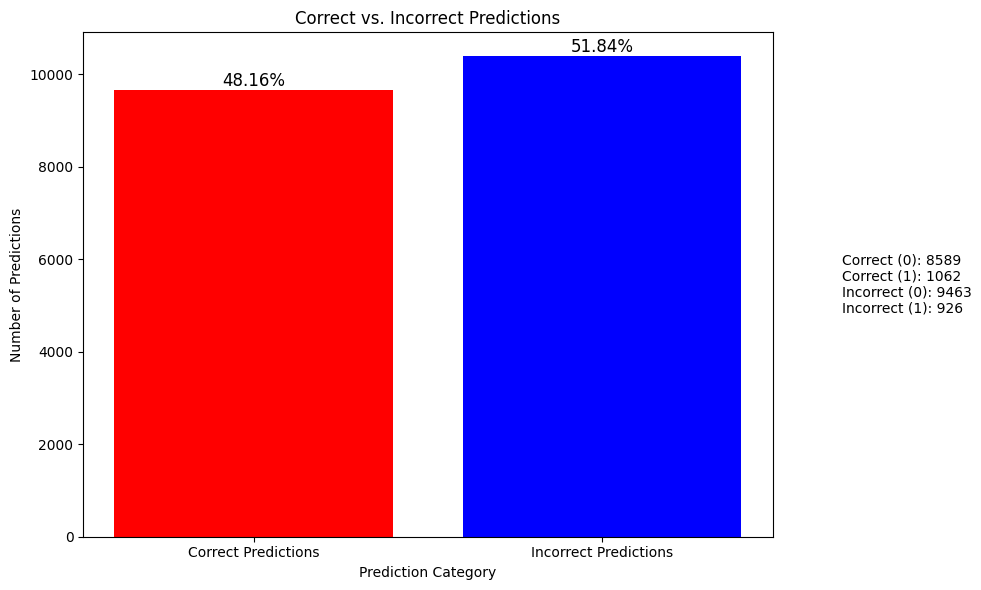

In [15]:
import matplotlib.pyplot as plt
# Calculate counts for correct and incorrect predictions
correct_predictions = predictions.filter(predictions.attiration == predictions.prediction)
incorrect_predictions = predictions.filter(predictions.attiration != predictions.prediction)

# Count the total number of predictions
total_predictions = predictions.count()

# Calculate overall counts
correct_count = correct_predictions.count()
incorrect_count = incorrect_predictions.count()

# Calculate percentages
correct_percentage = (correct_count / total_predictions) * 100
incorrect_percentage = (incorrect_count / total_predictions) * 100

# Count correct and incorrect predictions by label
correct_label_0 = correct_predictions.filter(correct_predictions.attiration == 0).count()
correct_label_1 = correct_predictions.filter(correct_predictions.attiration == 1).count()
incorrect_label_0 = incorrect_predictions.filter(incorrect_predictions.attiration == 0).count()
incorrect_label_1 = incorrect_predictions.filter(incorrect_predictions.attiration == 1).count()

# Print details
print(f"Correct Predictions: {correct_count} ({correct_percentage:.2f}%)")
print(f"  Correct Label 0: {correct_label_0}")
print(f"  Correct Label 1: {correct_label_1}")
print(f"Incorrect Predictions: {incorrect_count} ({incorrect_percentage:.2f}%)")
print(f"  Incorrect Label 0: {incorrect_label_0}")
print(f"  Incorrect Label 1: {incorrect_label_1}")

# Prepare data for bar chart
categories = ['Correct Predictions', 'Incorrect Predictions']
counts = [correct_count, incorrect_count]
percentages = [correct_percentage, incorrect_percentage]


plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['red', 'blue'])

# Annotate bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percentage:.2f}%',
             ha='center', va='bottom', fontsize=12)

plt.title('Correct vs. Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.xlabel('Prediction Category')

# Add detailed breakdown as text annotation
details = (f"Correct (0): {correct_label_0}\n"
           f"Correct (1): {correct_label_1}\n"
           f"Incorrect (0): {incorrect_label_0}\n"
           f"Incorrect (1): {incorrect_label_1}")
plt.gca().text(1.1, 0.5, details, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

# Display the plot
plt.tight_layout()
plt.show()


In [16]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="attiration", featuresCol="features", numTrees=50,weightCol="class_weights")
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

In [17]:
predictions = rf_model.transform(test_data)

predictions.select("features", "attiration", "prediction").show(20)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

+--------------------+----------+----------+
|            features|attiration|prediction|
+--------------------+----------+----------+
|[1.0,0.0,0.0,1.0,...|       0.0|       1.0|
|[3.0,0.0,2.0,0.0,...|       0.0|       0.0|
|[0.0,1.0,2.0,1.0,...|       0.0|       0.0|
|[8.0,0.0,3.0,0.0,...|       0.0|       0.0|
|[1.0,0.0,2.0,1.0,...|       0.0|       0.0|
|[4.0,0.0,5.0,2.0,...|       0.0|       0.0|
|[1.0,0.0,3.0,1.0,...|       0.0|       0.0|
|[7.0,1.0,4.0,2.0,...|       0.0|       1.0|
|[7.0,1.0,0.0,1.0,...|       0.0|       0.0|
|[7.0,0.0,2.0,0.0,...|       0.0|       1.0|
|[2.0,0.0,0.0,0.0,...|       0.0|       0.0|
|[2.0,2.0,6.0,1.0,...|       0.0|       0.0|
|[7.0,0.0,6.0,0.0,...|       0.0|       1.0|
|[0.0,1.0,6.0,0.0,...|       0.0|       0.0|
|[4.0,0.0,1.0,0.0,...|       0.0|       1.0|
|[4.0,0.0,1.0,2.0,...|       0.0|       1.0|
|[4.0,0.0,6.0,2.0,...|       0.0|       0.0|
|[1.0,1.0,4.0,1.0,...|       0.0|       1.0|
|[5.0,1.0,2.0,2.0,...|       0.0|       1.0|
|[5.0,0.0,

Correct Predictions: 11614 (57.95%)
  Correct Label 0: 10783
  Correct Label 1: 831
Incorrect Predictions: 8426 (42.05%)
  Incorrect Label 0: 7269
  Incorrect Label 1: 1157


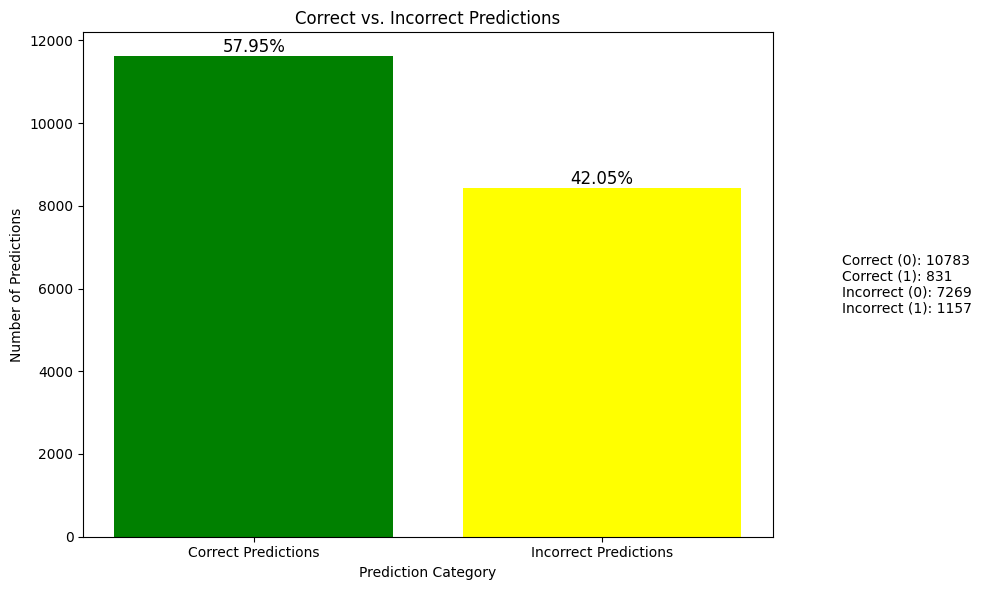

In [18]:

# Calculate counts for correct and incorrect predictions
correct_predictions = predictions.filter(predictions.attiration == predictions.prediction)
incorrect_predictions = predictions.filter(predictions.attiration != predictions.prediction)

# Count the total number of predictions
total_predictions = predictions.count()

# Calculate overall counts
correct_count = correct_predictions.count()
incorrect_count = incorrect_predictions.count()

# Calculate percentages
correct_percentage = (correct_count / total_predictions) * 100
incorrect_percentage = (incorrect_count / total_predictions) * 100

# Count correct and incorrect predictions by label
correct_label_0 = correct_predictions.filter(correct_predictions.attiration == 0).count()
correct_label_1 = correct_predictions.filter(correct_predictions.attiration == 1).count()
incorrect_label_0 = incorrect_predictions.filter(incorrect_predictions.attiration == 0).count()
incorrect_label_1 = incorrect_predictions.filter(incorrect_predictions.attiration == 1).count()

# Print details
print(f"Correct Predictions: {correct_count} ({correct_percentage:.2f}%)")
print(f"  Correct Label 0: {correct_label_0}")
print(f"  Correct Label 1: {correct_label_1}")
print(f"Incorrect Predictions: {incorrect_count} ({incorrect_percentage:.2f}%)")
print(f"  Incorrect Label 0: {incorrect_label_0}")
print(f"  Incorrect Label 1: {incorrect_label_1}")

# Prepare data for bar chart
categories = ['Correct Predictions', 'Incorrect Predictions']
counts = [correct_count, incorrect_count]
percentages = [correct_percentage, incorrect_percentage]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['green', 'yellow'])

# Annotate bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percentage:.2f}%',
             ha='center', va='bottom', fontsize=12)

plt.title('Correct vs. Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.xlabel('Prediction Category')

# Add detailed breakdown as text annotation
details = (f"Correct (0): {correct_label_0}\n"
           f"Correct (1): {correct_label_1}\n"
           f"Incorrect (0): {incorrect_label_0}\n"
           f"Incorrect (1): {incorrect_label_1}")
plt.gca().text(1.1, 0.5, details, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the GBTClassifier
gbt = GBTClassifier(labelCol="attiration", featuresCol="features", maxIter=100, seed=42)

# Train the model on the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)



# Display predictions
predictions.select("features", "Resigned", "prediction").show(20)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="Resigned", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


+--------------------+--------+----------+
|            features|Resigned|prediction|
+--------------------+--------+----------+
|[1.0,0.0,0.0,1.0,...|       0|       0.0|
|[3.0,0.0,2.0,0.0,...|       0|       0.0|
|[0.0,1.0,2.0,1.0,...|       0|       0.0|
|[8.0,0.0,3.0,0.0,...|       0|       0.0|
|[1.0,0.0,2.0,1.0,...|       0|       0.0|
|[4.0,0.0,5.0,2.0,...|       0|       0.0|
|[1.0,0.0,3.0,1.0,...|       0|       0.0|
|[7.0,1.0,4.0,2.0,...|       0|       0.0|
|[7.0,1.0,0.0,1.0,...|       0|       0.0|
|[7.0,0.0,2.0,0.0,...|       0|       0.0|
|[2.0,0.0,0.0,0.0,...|       0|       0.0|
|[2.0,2.0,6.0,1.0,...|       0|       0.0|
|[7.0,0.0,6.0,0.0,...|       0|       0.0|
|[0.0,1.0,6.0,0.0,...|       0|       0.0|
|[4.0,0.0,1.0,0.0,...|       0|       0.0|
|[4.0,0.0,1.0,2.0,...|       0|       0.0|
|[4.0,0.0,6.0,2.0,...|       0|       0.0|
|[1.0,1.0,4.0,1.0,...|       0|       0.0|
|[5.0,1.0,2.0,2.0,...|       0|       0.0|
|[5.0,0.0,1.0,1.0,...|       0|       0.0|
+----------

Correct Predictions: 18051 (90.07%)
  Correct Label 0: 18051
  Correct Label 1: 0
Incorrect Predictions: 1989 (9.93%)
  Incorrect Label 0: 1
  Incorrect Label 1: 1988


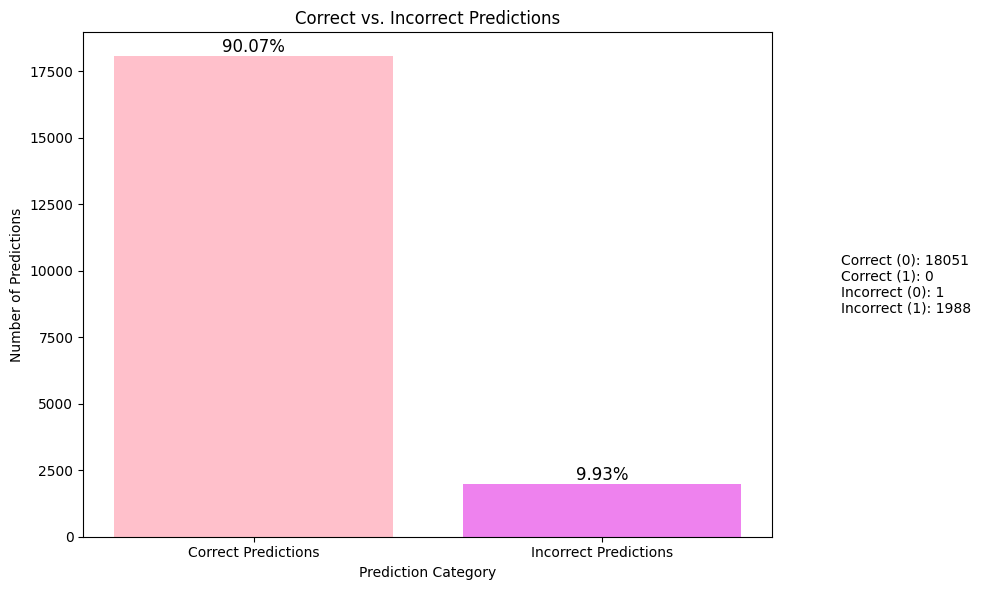

In [20]:

# Calculate counts for correct and incorrect predictions
correct_predictions = predictions.filter(predictions.attiration == predictions.prediction)
incorrect_predictions = predictions.filter(predictions.attiration != predictions.prediction)

# Count the total number of predictions
total_predictions = predictions.count()

# Calculate overall counts
correct_count = correct_predictions.count()
incorrect_count = incorrect_predictions.count()

# Calculate percentages
correct_percentage = (correct_count / total_predictions) * 100
incorrect_percentage = (incorrect_count / total_predictions) * 100

# Count correct and incorrect predictions by label
correct_label_0 = correct_predictions.filter(correct_predictions.attiration == 0).count()
correct_label_1 = correct_predictions.filter(correct_predictions.attiration == 1).count()
incorrect_label_0 = incorrect_predictions.filter(incorrect_predictions.attiration == 0).count()
incorrect_label_1 = incorrect_predictions.filter(incorrect_predictions.attiration == 1).count()

# Print details
print(f"Correct Predictions: {correct_count} ({correct_percentage:.2f}%)")
print(f"  Correct Label 0: {correct_label_0}")
print(f"  Correct Label 1: {correct_label_1}")
print(f"Incorrect Predictions: {incorrect_count} ({incorrect_percentage:.2f}%)")
print(f"  Incorrect Label 0: {incorrect_label_0}")
print(f"  Incorrect Label 1: {incorrect_label_1}")

# Prepare data for bar chart
categories = ['Correct Predictions', 'Incorrect Predictions']
counts = [correct_count, incorrect_count]
percentages = [correct_percentage, incorrect_percentage]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['pink', 'violet'])

# Annotate bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percentage:.2f}%',
             ha='center', va='bottom', fontsize=12)

plt.title('Correct vs. Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.xlabel('Prediction Category')

# Add detailed breakdown as text annotation
details = (f"Correct (0): {correct_label_0}\n"
           f"Correct (1): {correct_label_1}\n"
           f"Incorrect (0): {incorrect_label_0}\n"
           f"Incorrect (1): {incorrect_label_1}")
plt.gca().text(1.1, 0.5, details, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

# Display the plot
plt.tight_layout()
plt.show()

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="attiration", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.900748502994012
Precision: 0.8114333038598684
Recall: 0.900748502994012
F1 Score: 0.8537613596937809


<ipython-input-22-d50f79d66a00>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Percentage", y="Feature", palette="viridis")


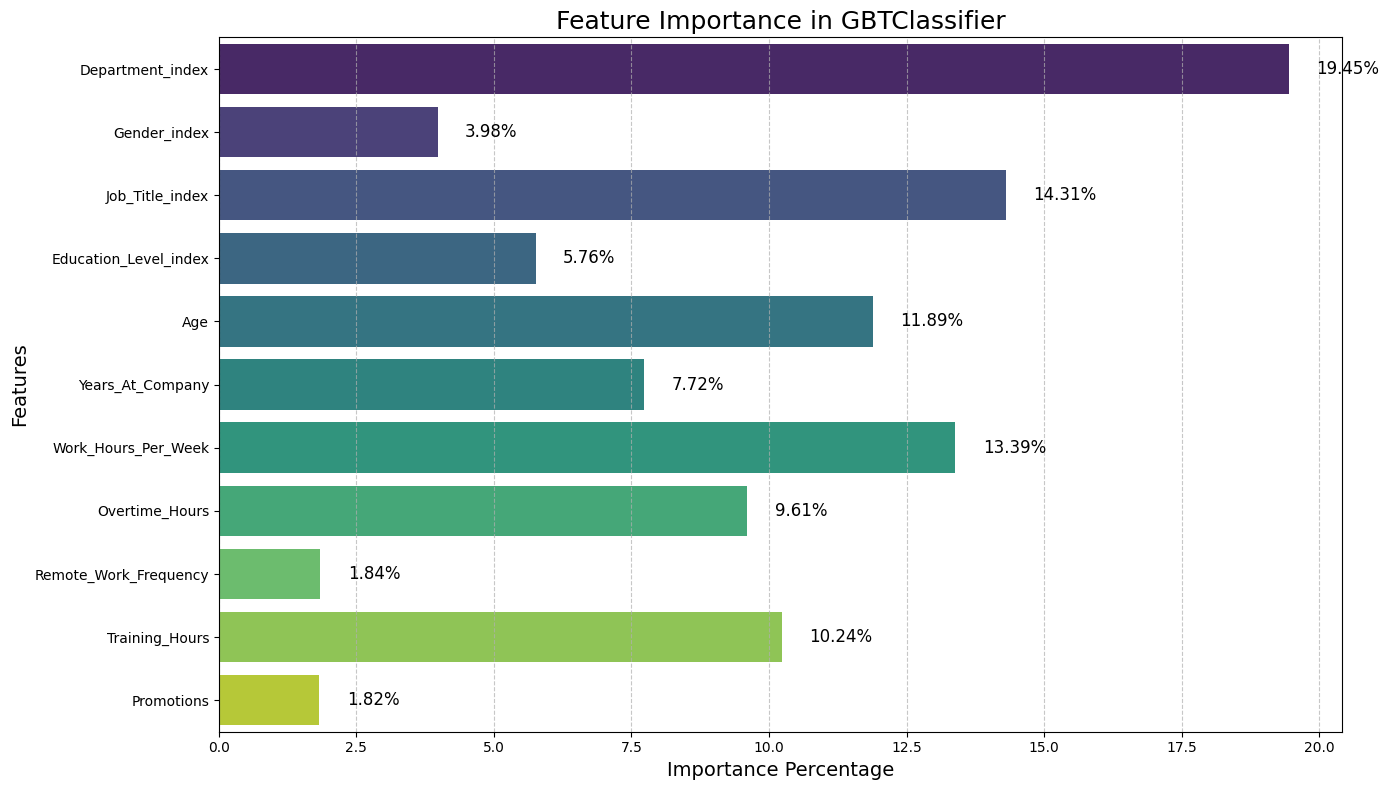

In [22]:
# Import necessary libraries

import pandas as pd
import seaborn as sns


# Feature names based on your `VectorAssembler`
features = [
    "Department_index",
    "Gender_index",
    "Job_Title_index",
    "Education_Level_index",
    "Age",
    "Years_At_Company",
    "Work_Hours_Per_Week",
    "Overtime_Hours",
    "Remote_Work_Frequency",
    "Training_Hours",
    "Promotions"
]

# Extract the feature importances
feature_importances = gbt_model.featureImportances.toArray()

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
})

# Calculate percentages for better interpretability
importance_df["Percentage"] = (importance_df["Importance"] / importance_df["Importance"].sum()) * 100



# Plot feature importance with percentages
plt.figure(figsize=(14, 8))
sns.barplot(data=importance_df, x="Percentage", y="Feature", palette="viridis")

# Add percentages as text labels on the bars
for index, row in importance_df.iterrows():
    plt.text(
        row["Percentage"] + 0.5,  # Position to the right of the bar
        index,  # Vertical position matches the bar
        f"{row['Percentage']:.2f}%",  # Format percentage with 2 decimals
        color="black",
        va="center",
        fontsize=12
    )

# Customize plot appearance
plt.title("Feature Importance in GBTClassifier", fontsize=18)
plt.xlabel("Importance Percentage", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()